In [1]:
# SECTION 1: Load and Preprocess Council Area Dataset

import pandas as pd

# Upload files manually in Colab using:
from google.colab import files
files.upload()

# Load datasets
df_mort_hbr = pd.read_csv('hd_mortalitybyhbr.csv')
df_act_hbr = pd.read_csv('hd_activitybyhbr.csv')


In [2]:
# Column descriptions based on Scottish Health and Social Care Open Data:
# 'HBR' = Health Board Region code
# 'AgeGroup' = Age bracket (e.g., '65-74 years')
# 'Sex' = Gender (Males/Females)
# 'CrudeRate_act' = Crude hospital discharge rate for CHD
# 'NumberOfDischarges' = CHD hospital discharge count
# 'EASR_mort' = European Age-Standardised CHD mortality rate (target)
# Convert FinancialYear to integer Year
df_act_hbr['Year'] = df_act_hbr['FinancialYear'].str[:4].astype(int)

# Merge on Year, HBR, AgeGroup, Sex
def prepare_hbr_dataset(df_mort, df_act):
    merged = pd.merge(df_mort, df_act, how='inner',
                      on=['Year', 'HBR', 'AgeGroup', 'Sex'],
                      suffixes=('_mort', '_act'))
    df_model = merged[[
        'Year', 'AgeGroup', 'Sex', 'HBR',
        'CrudeRate_act', 'NumberOfDischarges',
        'EASR_mort'
    ]].dropna()
    return df_model

# Apply merge
df_hbr = prepare_hbr_dataset(df_mort_hbr, df_act_hbr)
# Check for presence of QF (Quality Flag) columns
qf_cols = [col for col in df_hbr.columns if 'QF' in col]
print("Detected QF Columns:", qf_cols)

if qf_cols:
    print("\nMissing values per QF column:")
    print(df_hbr[qf_cols].isnull().sum())

    print("\nSample value distributions in QF columns:")
    for col in qf_cols:
        print(f"{col} value counts:\n", df_hbr[col].value_counts(dropna=False), "\n")


# Preview
df_hbr.head()

Detected QF Columns: []


,Year,AgeGroup,Sex,HBR,CrudeRate_act,NumberOfDischarges,EASR_mort
0,2013,0-44 years,Males,S08000015,114.457246,106.0,8.09556
1,2013,0-44 years,Males,S08000015,18.356351,17.0,8.09556
2,2013,0-44 years,Males,S08000015,37.792487,35.0,8.09556
3,2013,0-44 years,Males,S08000015,58.308408,54.0,8.09556
4,2013,0-44 years,Males,S08000015,79.904115,74.0,8.09556


                Year  CrudeRate_act  NumberOfDischarges      EASR_mort
count  114855.000000  114855.000000       114855.000000  114855.000000
mean     2017.507797     347.387580          530.103591     135.214743
std         2.872383     636.669100         1892.379184     263.516982
min      2013.000000       0.000000            0.000000       0.000000
25%      2015.000000      11.091885           11.000000       2.134172
50%      2018.000000     101.270593           85.000000      34.990437
75%      2020.000000     376.397012          346.000000     114.325961
max      2022.000000    7234.214650        51473.000000    2409.366051


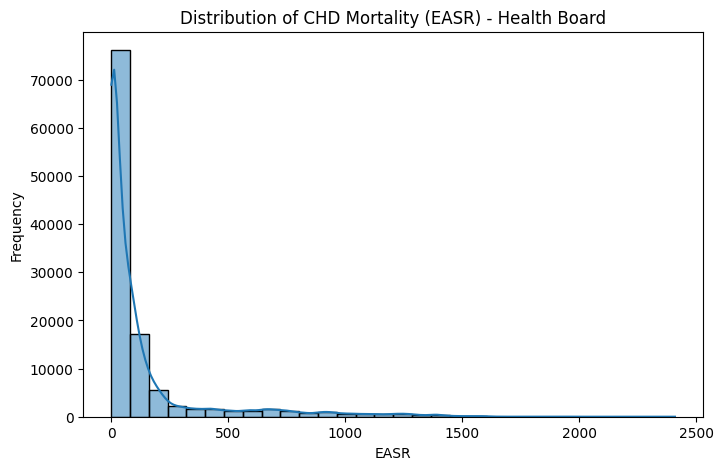

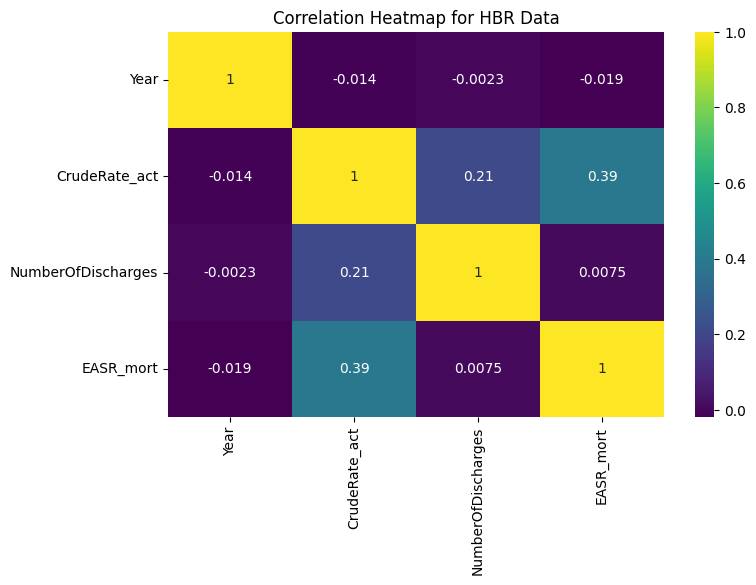

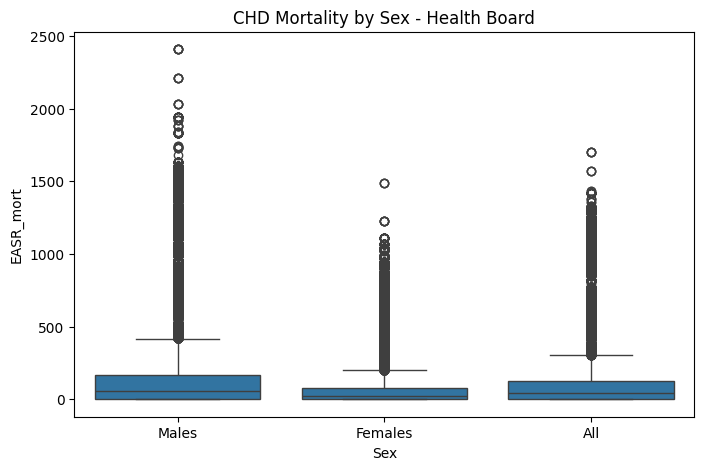

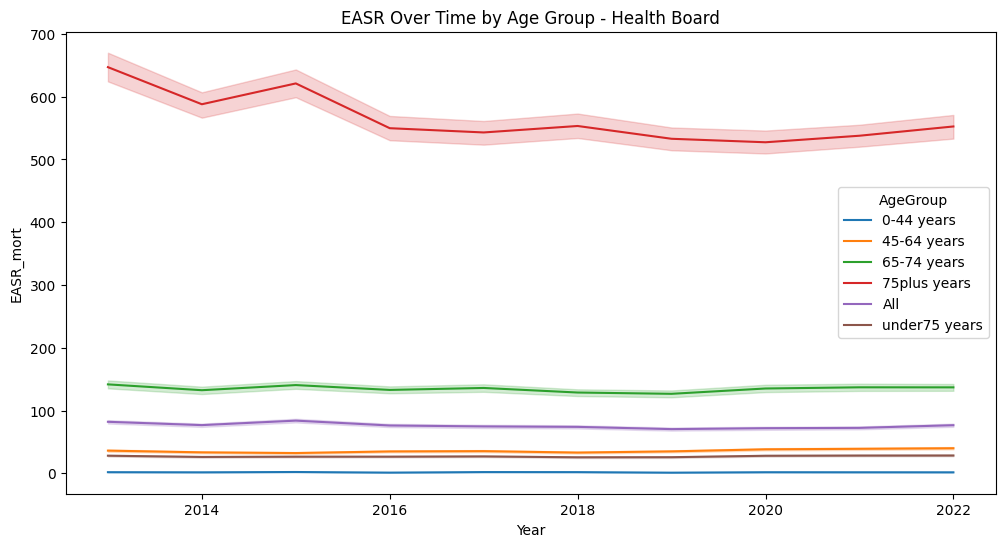

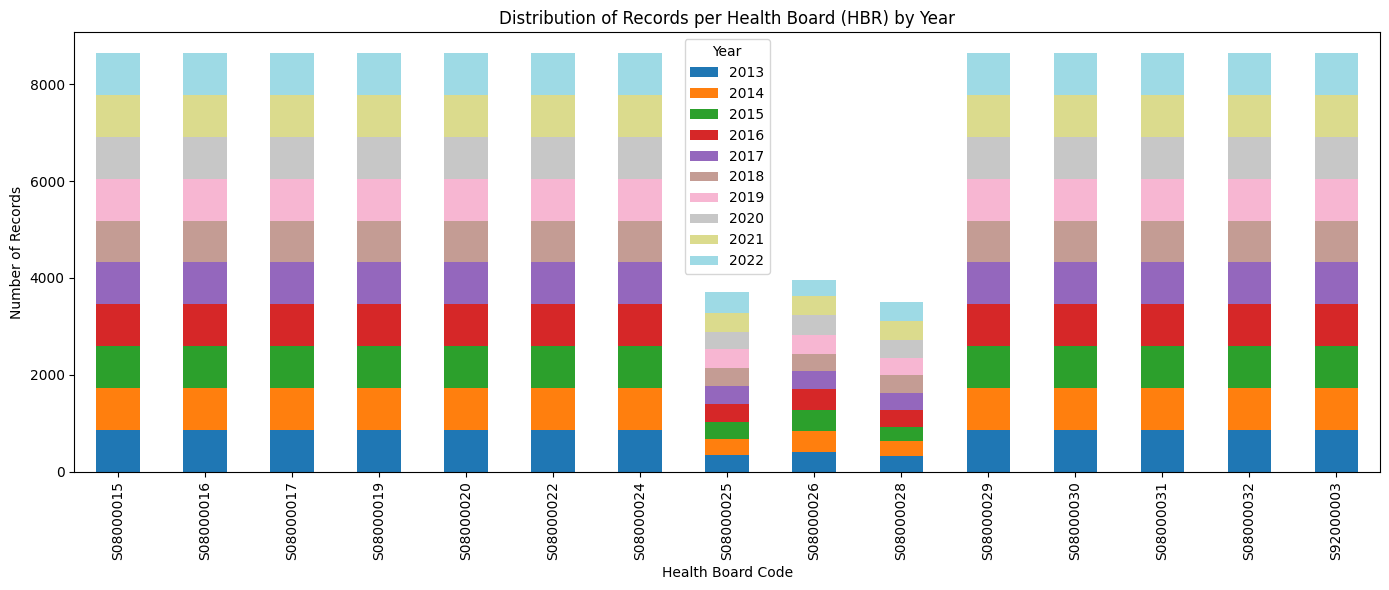

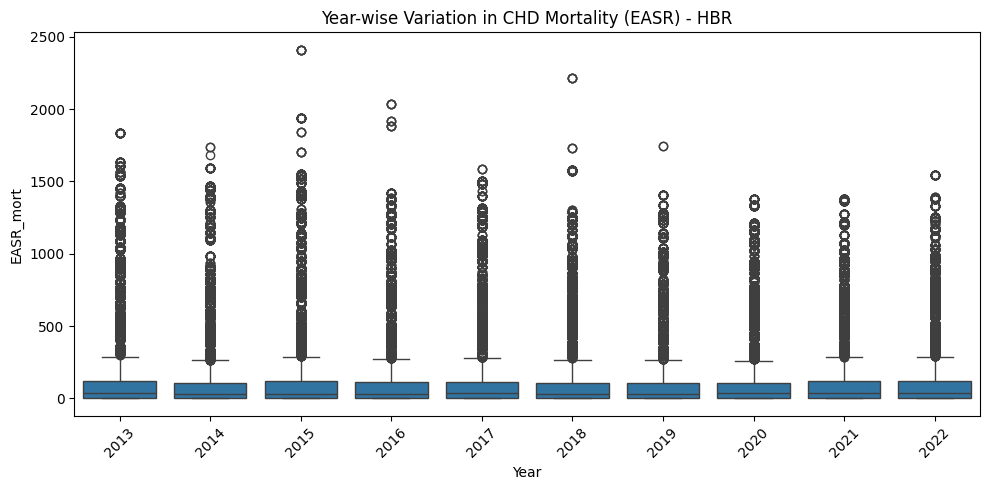

In [3]:
# SECTION 2-HBR: EDA for Health Board Dataset

import seaborn as sns
import matplotlib.pyplot as plt

# Summary stats
print(df_hbr.describe())

# Distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(df_hbr['EASR_mort'], bins=30, kde=True)
plt.title("Distribution of CHD Mortality (EASR) - Health Board")
plt.xlabel("EASR")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df_hbr.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title("Correlation Heatmap for HBR Data")
plt.show()

# Boxplot by Sex
plt.figure(figsize=(8,5))
sns.boxplot(x='Sex', y='EASR_mort', data=df_hbr)
plt.title("CHD Mortality by Sex - Health Board")
plt.show()

# Lineplot by Year and Age Group
plt.figure(figsize=(12,6))
sns.lineplot(data=df_hbr, x='Year', y='EASR_mort', hue='AgeGroup')
plt.title("EASR Over Time by Age Group - Health Board")
plt.show()
# Check record distribution per Health Board across years
import matplotlib.pyplot as plt
import seaborn as sns

hbr_counts = df_hbr.groupby(['Year', 'HBR']).size().unstack(fill_value=0)
hbr_counts.T.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Distribution of Records per Health Board (HBR) by Year")
plt.xlabel("Health Board Code")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

# Boxplot of EASR_mort by year
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_hbr, x='Year', y='EASR_mort')
plt.title("Year-wise Variation in CHD Mortality (EASR) - HBR")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


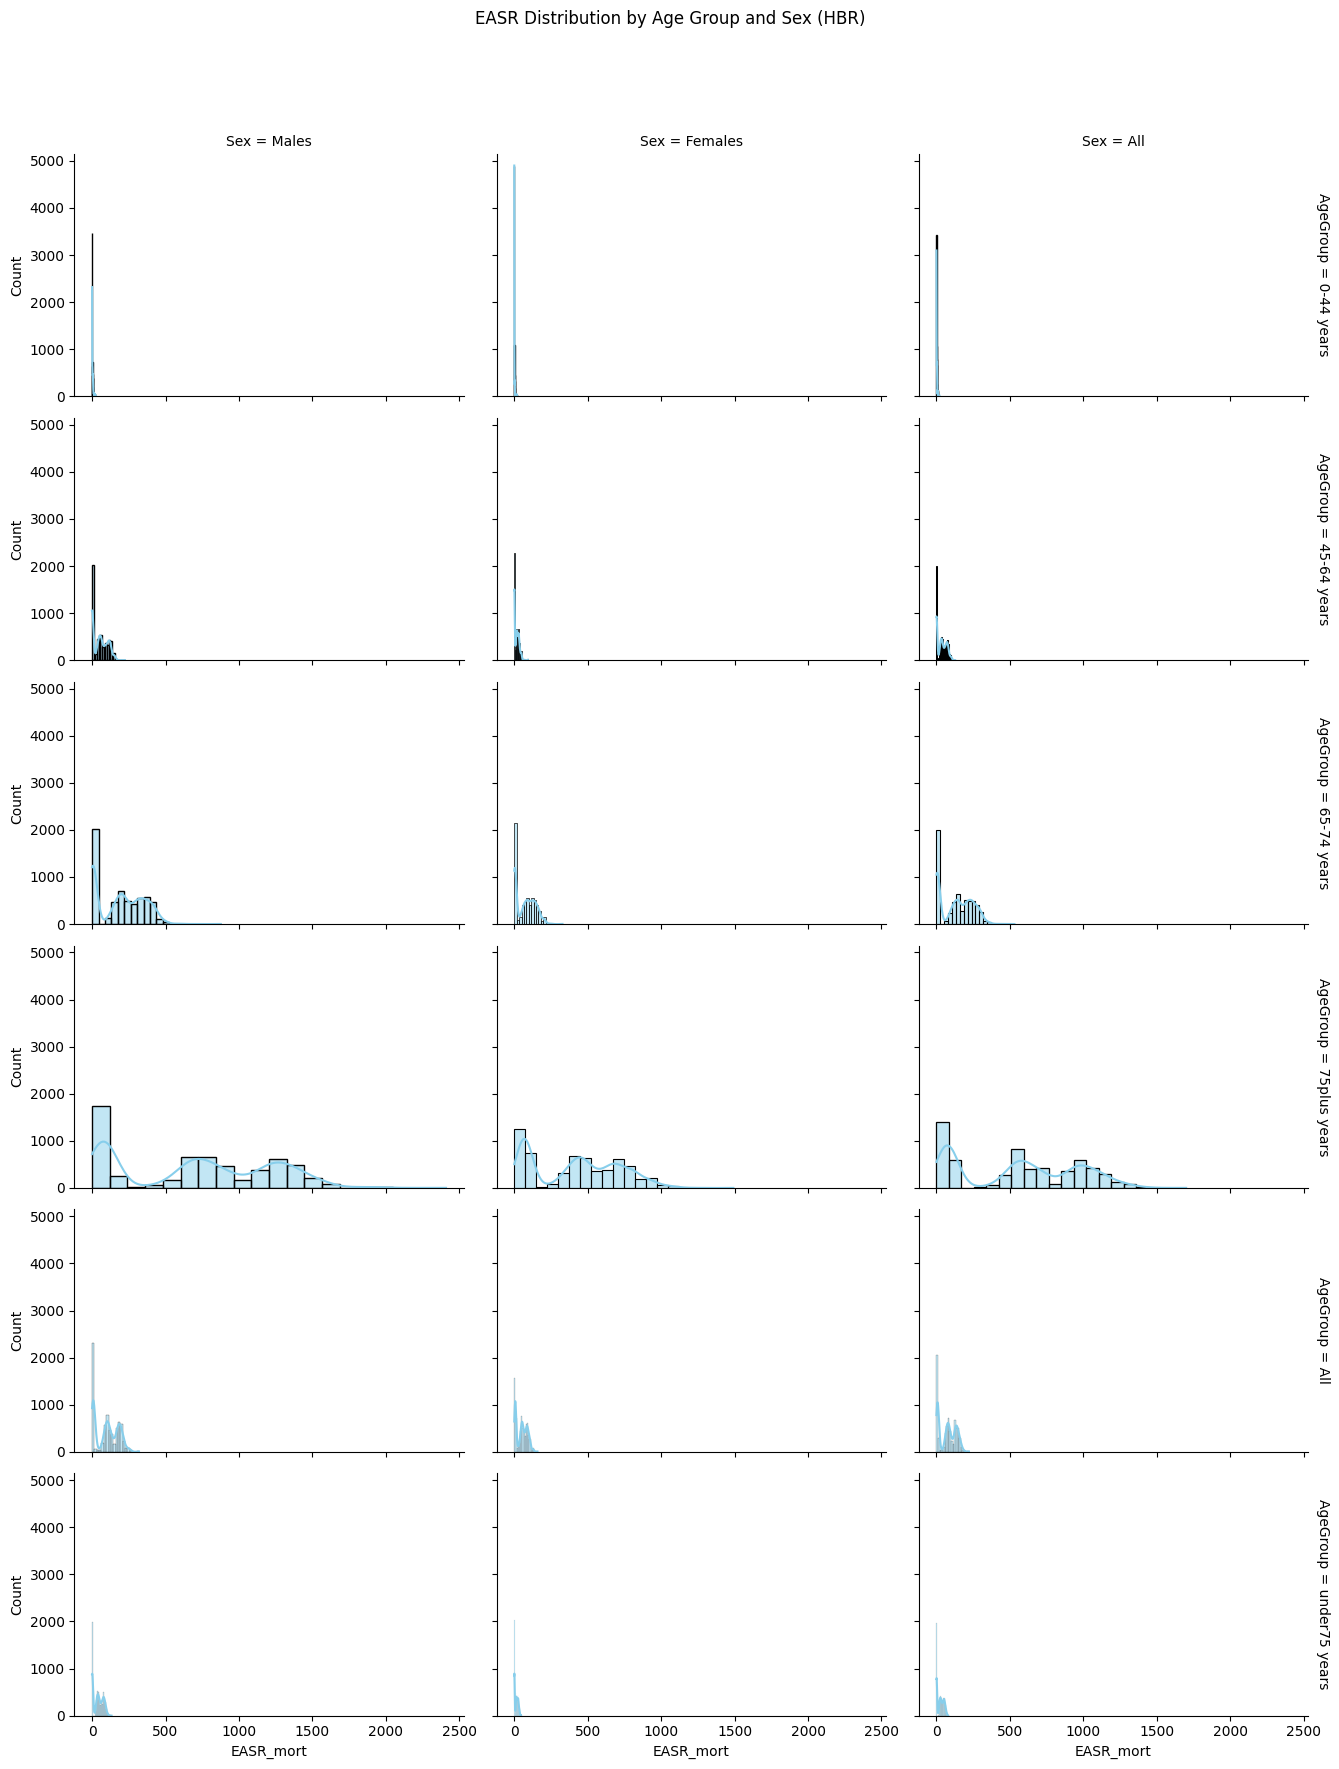

In [4]:
# Swarmplot: EASR by Age Group Colored by Year
g = sns.FacetGrid(df_hbr, row="AgeGroup", col="Sex", margin_titles=True, height=3, aspect=1.5)
g.map(sns.histplot, "EASR_mort", bins=20, kde=True, color='skyblue')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("EASR Distribution by Age Group and Sex (HBR)")
plt.show()

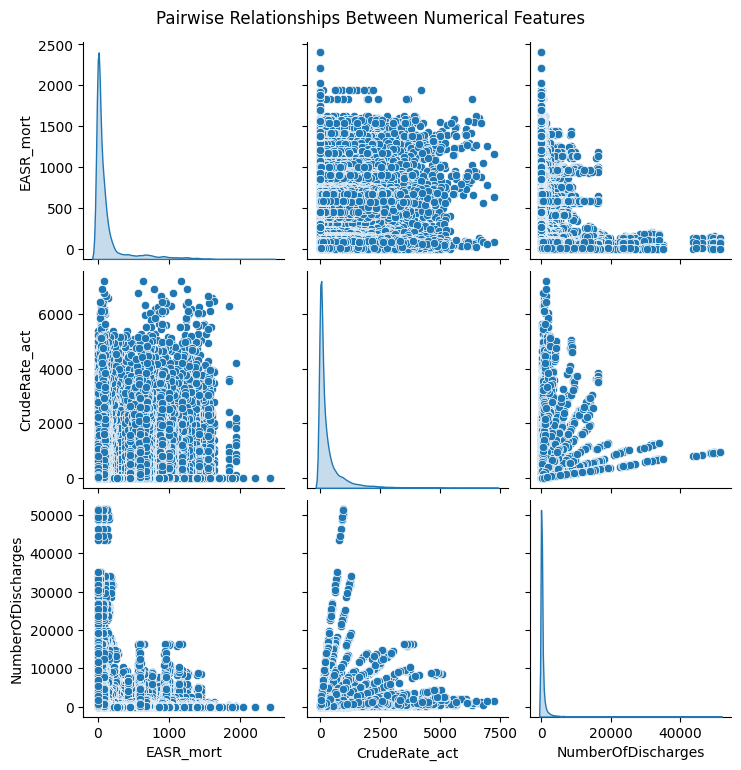

In [5]:
# Pairplot: Multi-Variable Relationship View
sns.pairplot(df_hbr[['EASR_mort', 'CrudeRate_act', 'NumberOfDischarges']], diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Numerical Features", y=1.02)
plt.show()

/tmp/ipython-input-6-1105240559.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_hbr, x='AgeGroup', y='EASR_mort', palette='pastel')


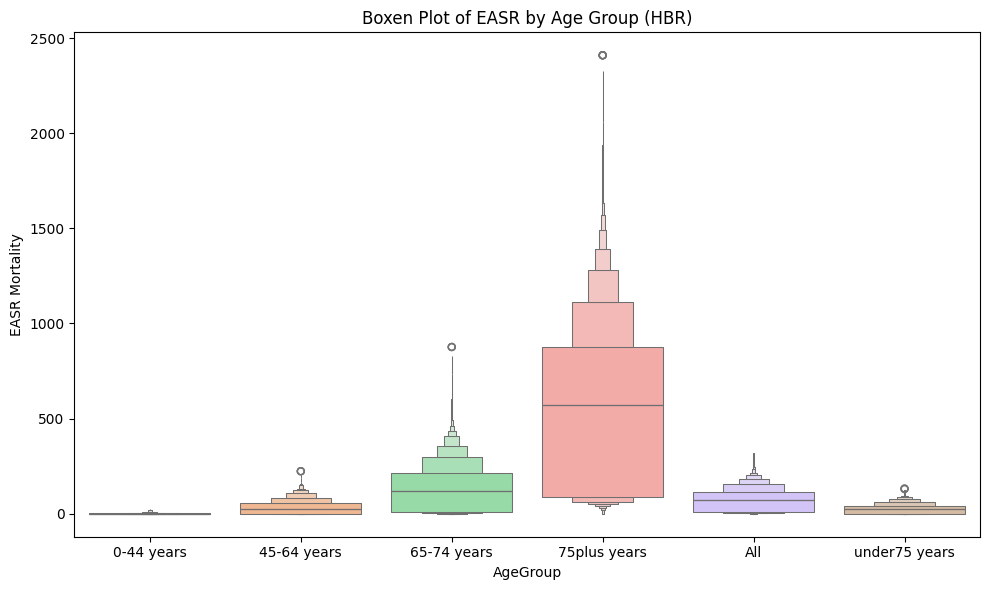

In [6]:
# Boxen Plot: EASR by Age Group (More Insight on Tails/Outliers)
plt.figure(figsize=(10, 6))
sns.boxenplot(data=df_hbr, x='AgeGroup', y='EASR_mort', palette='pastel')
plt.title("Boxen Plot of EASR by Age Group (HBR)")
plt.ylabel("EASR Mortality")
plt.tight_layout()
plt.show()

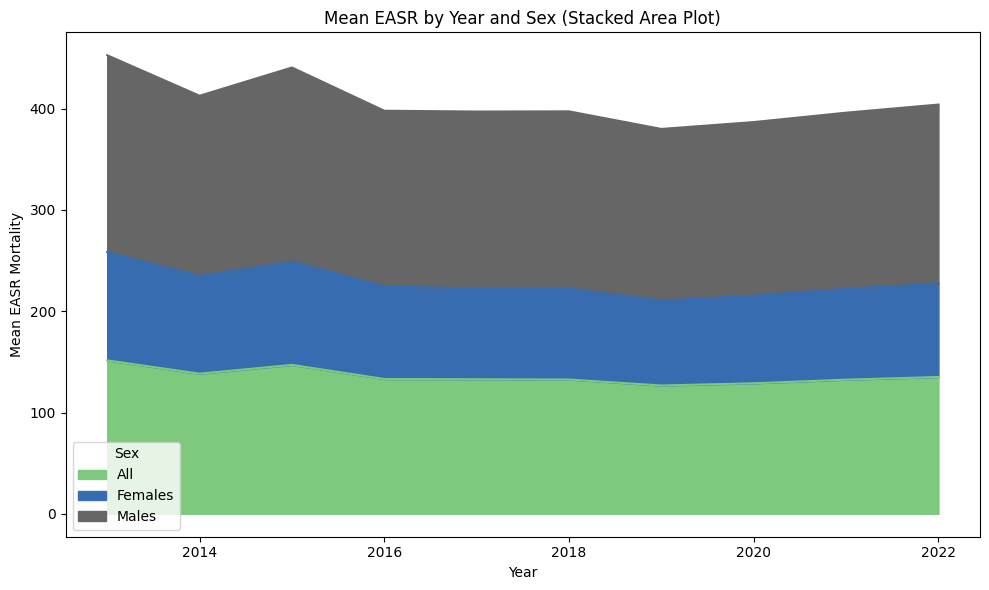

In [7]:
# Stacked Area Plot: Mean EASR by Year and Sex
df_area = df_hbr.groupby(['Year', 'Sex'])['EASR_mort'].mean().unstack()
df_area.plot(kind='area', stacked=True, figsize=(10, 6), colormap='Accent')
plt.title("Mean EASR by Year and Sex (Stacked Area Plot)")
plt.ylabel("Mean EASR Mortality")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

In [8]:
# SECTION 3-HBR: Feature Encoding and Splitting

from sklearn.model_selection import train_test_split

# One-hot encode categorical variables
df_hbr_encoded = pd.get_dummies(df_hbr, columns=['Sex', 'AgeGroup', 'HBR'], drop_first=True)

# Define X (features) and y (target)
X_hbr = df_hbr_encoded.drop('EASR_mort', axis=1)
y_hbr = df_hbr_encoded['EASR_mort']

# Train-test split
X_train_hbr, X_test_hbr, y_train_hbr, y_test_hbr = train_test_split(
    X_hbr, y_hbr, test_size=0.2, random_state=42
)

# Confirm shape
print("Training set shape:", X_train_hbr.shape)
print("Test set shape:", X_test_hbr.shape)


Training set shape: (91884, 24)
Test set shape: (22971, 24)


In [9]:
# SECTION 4: Model Development with Hyperparameter Tuning

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models_hbr = {
    "Linear Regression": (LinearRegression(), {}),
    "Decision Tree": (DecisionTreeRegressor(random_state=42), {"max_depth": [3,5,7,10]}),
    "Random Forest": (RandomForestRegressor(random_state=42), {"n_estimators": [50,100], "max_depth": [5,10,15]}),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {"n_estimators": [100,200], "learning_rate": [0.05,0.1]}),
    "SVR": (SVR(kernel='rbf'), {"C": [1,10], "epsilon": [0.1,0.2]})
}

best_models_hbr = {}
results_hbr = []

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2}

for name, (model, params) in models_hbr.items():
    grid = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train_hbr, y_train_hbr)
    best_models_hbr[name] = grid.best_estimator_
    preds = grid.predict(X_test_hbr)
    results_hbr.append(evaluate_model(name, y_test_hbr, preds))

results_hbr_df = pd.DataFrame(results_hbr)
print("\nModel Performance Summary (HBR):\n", results_hbr_df)


Model Performance Summary (HBR):
                Model         MAE        RMSE        R²
0  Linear Regression   94.352910  176.551808  0.556634
1      Decision Tree   86.096383  172.526538  0.576620
2      Random Forest   85.970548  172.271945  0.577869
3  Gradient Boosting   87.921547  172.365131  0.577412
4                SVR  117.929570  253.123743  0.088652



Best Performing Model (HBR): Random Forest


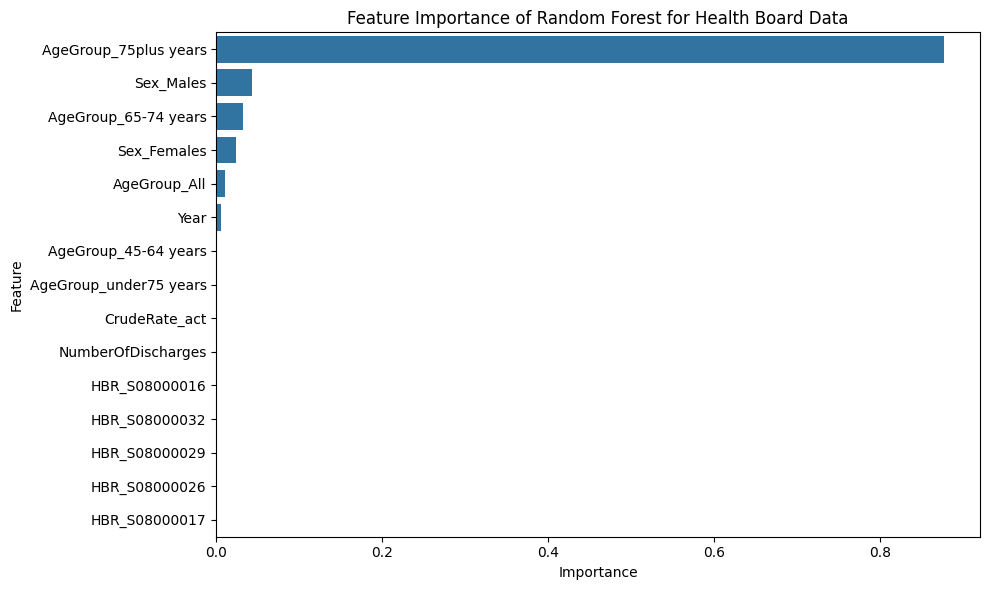

In [10]:
# SECTION 5: Feature Importance for Best Model

best_model_name_hbr = results_hbr_df.sort_values(by="R²", ascending=False).iloc[0]["Model"]
print(f"\nBest Performing Model (HBR): {best_model_name_hbr}")

if best_model_name_hbr in ["Random Forest", "Gradient Boosting", "Decision Tree"]:
    best_model_hbr = best_models_hbr[best_model_name_hbr]
    importance = best_model_hbr.feature_importances_
    feature_df = pd.DataFrame({'Feature': X_hbr.columns, 'Importance': importance})
    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10,6))
    sns.barplot(data=feature_df, x='Importance', y='Feature')
    plt.title(f"Feature Importance of {best_model_name_hbr} for Health Board Data")
    plt.tight_layout()
    plt.show()